**importing libraries**

In [218]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from snowflake.connector.pandas_tools import pd_writer

### looking into data


- stops.txt
- calendar_dates.txt
- calendar.txt
- routes.txt
- shapes.txt
- stop_times.txt
- trips.txt
- agency.txt

In [5]:
# Loading data
stops = pd.read_csv("stops.txt")
stop_times = pd.read_csv("stop_times.txt")
shapes = pd.read_csv("shapes.txt")
trips = pd.read_csv("trips.txt")
routes = pd.read_csv("routes.txt")
calendar = pd.read_csv("calendar.txt")
calendar_dates = pd.read_csv("calendar_dates.txt")

### Data Prepatation and Cleansing

Starting preperation with two connected tables: stops and stop_times

In [6]:
stops.head(2)

stop_id                   stop_name  stop_desc   stop_lat   stop_lon  \
0   300000  ORIENTAL BLVD/MACKENZIE ST        NaN  40.578350 -73.940029   
1   300002    ORIENTAL BLVD/JAFFRAY ST        NaN  40.578066 -73.943029   

   zone_id  stop_url  location_type  parent_station  
0      NaN       NaN              0             NaN  
1      NaN       NaN              0             NaN

In [8]:
stops.isnull().sum()

stop_id              0
stop_name            0
stop_desc         4619
stop_lat             0
stop_lon             0
zone_id           4619
stop_url          4619
location_type        0
parent_station    4619
dtype: int64

In [9]:
# drop columns with null values
stops = stops.drop(['stop_desc','zone_id','stop_url','parent_station'], axis = 1)

In [11]:
stops.dtypes

stop_id            int64
stop_name         object
stop_lat         float64
stop_lon         float64
location_type      int64
dtype: object

In [12]:
# Tranforming stop_name into string
stops['stop_name'] = stops['stop_name'].astype('string')

In [13]:
stops['location_type'].unique()

array([0], dtype=int64)

In [14]:
# let's drop unecessary column
stops = stops.drop('location_type',axis=1)

In [15]:
stops.head(2)

stop_id                   stop_name   stop_lat   stop_lon
0   300000  ORIENTAL BLVD/MACKENZIE ST  40.578350 -73.940029
1   300002    ORIENTAL BLVD/JAFFRAY ST  40.578066 -73.943029

In [16]:
stop_times.head(2)

trip_id arrival_time departure_time  stop_id  \
0  EN_B5-Weekday-028500_SBS82_901     04:45:00       04:45:00   304083   
1  EN_B5-Weekday-028500_SBS82_901     04:47:37       04:47:37   304085   

   stop_sequence  pickup_type  drop_off_type  timepoint  
0              1            0              0          1  
1              2            0              0          0

In [34]:
stop_times['drop_off_type'].unique()

array([0, 1], dtype=int64)

In [18]:
stop_times.dtypes

trip_id           object
arrival_time      object
departure_time    object
stop_id            int64
stop_sequence      int64
pickup_type        int64
drop_off_type      int64
timepoint          int64
dtype: object

In [21]:
stop_times['trip_id']        = stop_times['trip_id'].astype('string')
stop_times['arrival_time']   = stop_times['arrival_time'].astype('string')
stop_times['departure_time'] = stop_times['departure_time'].astype('string')

In [23]:
# Let's merge for further analytics and data aggregation
stops_and_times = stop_times.merge(stops, on = 'stop_id', how = 'left')

In [24]:
stops_and_times.shape

(1994835, 11)

**Trips, shapes and routes**

In [46]:
trips.head(2)

route_id     service_id                         trip_id  \
0     B82+  EN_B5-Weekday  EN_B5-Weekday-028500_SBS82_901   
1     B82+  EN_B5-Weekday  EN_B5-Weekday-034800_SBS82_901   

                              trip_headsign  direction_id  block_id   shape_id  
0  SELECT BUS BENSNHRST BAY 38 via FLATLNDS             1  37195534  SBS821519  
1   SELECT BUS SPRING CRK SEAVIEW via KINGS             0  37195534  SBS821520

In [48]:
trips['trip_id']        = trips['trip_id'].astype('string')
trips['service_id']     = trips['service_id'].astype('string')
trips['trip_headsign']  = trips['trip_headsign'].astype('string')
trips['route_id']       = trips['route_id'].astype('string')
trips['shape_id']       = trips['shape_id'].astype('string')

In [49]:
trips.dtypes

route_id         string[python]
service_id       string[python]
trip_id          string[python]
trip_headsign    string[python]
direction_id              int64
block_id                  int64
shape_id         string[python]
dtype: object

In [52]:
shapes.head(2)

shape_id  shape_pt_lat  shape_pt_lon  shape_pt_sequence
0   B10025     40.578199    -73.939761              10001
1   B10025     40.578252    -73.939799              10002

In [68]:
shapes.isnull().sum()

shape_id             0
shape_pt_lat         0
shape_pt_lon         0
shape_pt_sequence    0
dtype: int64

In [70]:
shapes['shape_id'] = shapes['shape_id'].astype('string')

In [71]:
shapes.dtypes

shape_id             string[python]
shape_pt_lat                float64
shape_pt_lon                float64
shape_pt_sequence             int64
dtype: object

In [77]:
routes.head(2)

route_id agency_id route_short_name              route_long_name  \
0       B1  MTA NYCT               B1  Bay Ridge - Manhattan Beach   
1      B11  MTA NYCT              B11        Sunset Park - Midwood   

                      route_desc  route_type route_color route_text_color  
0       via 86th St / Ocean Pkwy           3      00AEEF           FFFFFF  
1  via 49th & 50th St / Avenue J           3      006CB7           FFFFFF

In [78]:
routes.isnull().sum()

route_id            0
agency_id           0
route_short_name    0
route_long_name     0
route_desc          5
route_type          0
route_color         0
route_text_color    0
dtype: int64

In [82]:
# drop null values
routes.dropna(subset=['route_desc'], inplace=True)

In [91]:
print(routes['agency_id'].unique())
print(routes['route_type'].unique())
print(routes['route_text_color'].unique())

['MTA NYCT']
[  3 711]
['FFFFFF']


In [92]:
# drop unecessary columns
routes = routes.drop(['agency_id', 'route_text_color'], axis = 1)

In [93]:
routes['route_id']             = routes['route_id'].astype('string')
routes['route_short_name']     = routes['route_short_name'].astype('string')
routes['route_long_name']      = routes['route_long_name'].astype('string')
routes['route_desc']           = routes['route_desc'].astype('string')
routes['route_color']          = routes['route_color'].astype('string')

In [94]:
routes.dtypes

route_id            string[python]
route_short_name    string[python]
route_long_name     string[python]
route_desc          string[python]
route_type                   int64
route_color         string[python]
dtype: object

**Calendar and Calendar dates**

In [100]:
calendar.head(2)

service_id  monday  tuesday  wednesday  thursday  friday  saturday  \
0   EN_B5-Sunday       0        0          0         0       0         0   
1  EN_B5-Weekday       1        1          1         1       1         0   

   sunday start_date   end_date  
0       1 2025-01-30 2025-06-22  
1       0 2025-03-31 2025-06-27

In [99]:
# convert column date into datetime type
calendar['start_date'] = pd.to_datetime(calendar['start_date'], format='%Y%m%d')
calendar['end_date'] = pd.to_datetime(calendar['end_date'], format='%Y%m%d')

so we have 5 different situations.

- Sunday only
- Saturday only
- Friday only
- Weekdays (Mon–Thu) + Sunday
- Full Weekdays (Mon–Fri)

In [104]:
# convert weekdays into one categorical column
def classify_day(row):
    active_days = {day for day in ['monday','tuesday','wednesday','thursday','friday','saturday','sunday'] if row[day]}
    
    if active_days == {'monday','tuesday','wednesday','thursday','friday'}:
        return 'Weekday (Mon–Fri)'
    elif active_days == {'monday','tuesday','wednesday','thursday','sunday'}:
        return 'Weekday (Mon–Thu) + Sunday'
    elif active_days == {'friday'}:
        return 'Friday only'
    elif active_days == {'saturday'}:
        return 'Saturday only'
    elif active_days == {'sunday'}:
        return 'Sunday only'
    else:
        return 'Mixed/Other'
    
calendar['service_schedule'] = calendar.apply(classify_day, axis=1)

In [107]:
# lets drop uneccessary columns
calendar = calendar.drop(['monday','tuesday','wednesday','thursday','friday','saturday','sunday'], axis = 1)

In [112]:
calendar['service_id']        = calendar['service_id'].astype('string')
calendar['service_schedule']  = calendar['service_schedule'].astype('string')

In [113]:
calendar.dtypes

service_id          string[python]
start_date          datetime64[ns]
end_date            datetime64[ns]
service_schedule    string[python]
dtype: object

### EDA and Visualization

**Travel Time.** \
Travel Time will be calculated by finding the difference
between arrival_time of current stop and departure time of prev stop in sequences of stop's

In [128]:
# sort values by trip_id and stop's sequence
stops_and_times = stops_and_times.sort_values(by=['trip_id', 'stop_sequence'])

In [129]:
# converting arrival and departure time into the timestamp seconds for further math operations
def time_to_seconds(t):
    h,m,s = t.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)
stops_and_times['arrival_timestamp'] = stops_and_times['arrival_time'].apply(time_to_seconds)
stops_and_times['departure_timestamp'] = stops_and_times ['departure_time'].apply(time_to_seconds)

In [131]:
# adding new column which will have departure time of prev stop
stops_and_times['prev_stop_departure_timestamp'] = stops_and_times.groupby('trip_id')['departure_timestamp'].shift(1)
# Mark those stops that are first in sequence with 0 values of prev_stop_departure instead of NaN
stops_and_times['prev_stop_departure_timestamp'] = stops_and_times['prev_stop_departure_timestamp'].fillna(0)

In [135]:
# calculating difference between timestamps and putting into new column
stops_and_times['travel_time'] = stops_and_times['arrival_timestamp'] - stops_and_times['prev_stop_departure_timestamp']

In [138]:
# Set travel_time to 0 for the stops that goes first in the sequence of stops
stops_and_times.loc[stops_and_times['stop_sequence'] == 1, 'travel_time'] = 0

In [151]:
stops_and_times.head(2)

TRIP_ID ARRIVAL_TIME DEPARTURE_TIME  STOP_ID  \
182700  EN_B5-Saturday-000000_B42_501     00:00:00       00:00:00   303345   
182701  EN_B5-Saturday-000000_B42_501     00:00:26       00:00:26   308044   

        STOP_SEQUENCE  PICKUP_TYPE  DROP_OFF_TYPE  TIMEPOINT  \
182700              1            0              0          1   
182701              2            0              0          0   

                           STOP_NAME   STOP_LAT   STOP_LON  ARRIVAL_TIMESTAMP  \
182700  ROCKAWAY PKWY/SUBWAY STATION  40.645775 -73.901624                  0   
182701     ROCKAWAY PKWY/GLENWOOD RD  40.645075 -73.902291                 26   

        DEPARTURE_TIMESTAMP  PREV_STOP_DEPARTURE_TIMESTAMP  TRAVEL_TIME  
182700                    0                            0.0          0.0  
182701                   26                            0.0         26.0

**Average Travel Time per stop**

In [168]:
# cacluating average travel time for each stop
stops_avg_time = stops_and_times.groupby('stop_name').agg(avg_travel_time=('travel_time', 'mean')).reset_index()

In [169]:
# sorting by average travel time
stops_avg_time = stops_avg_time.sort_values(by='avg_travel_time', ascending = False)

In [170]:
stops_avg_time['avg_travel_time'].describe()

count    3384.000000
mean       70.712291
std        43.302424
min         0.000000
25%        48.821563
50%        63.606032
75%        82.051061
max      1245.300699
Name: avg_travel_time, dtype: float64

In [171]:
# Get the top 5 stops
top5 = stops_avg_time[:5]

In [172]:
top5

stop_name  avg_travel_time
1871  Gwnus Cntrline Ep-S/Gwnus Cntrline Ep-S      1245.300699
2269                   MEEKER AV/KINGSLAND AV       565.237805
1869                Gowanus Exp./22 St (N.B.)       512.210863
3374     hugh carey tunnel/west st.non-public       466.575758
2747               QUEENS MIDTOWN EXPWY/48 ST       430.343373

**Average Travel time per hour**

In [174]:
hourly_avg_time = stops_and_times.copy() # deep copy of our table

In [175]:
# fixing timestamp where some times are exceeding the 24 hours format
def fix_time(t):
    h, m, s = map(int, t.split(':'))
    if h >= 24:
        h -= 24
        return f'{h:02}:{m:02}:{s:02}'
    return t
hourly_avg_time['arrival_time'] = hourly_avg_time['arrival_time'].apply(fix_time)                

In [180]:
# Adding new columm 
hourly_avg_time['arrival_hour'] = pd.to_datetime(hourly_avg_time['arrival_time'], format='%H:%M:%S').dt.hour

In [181]:
hourly_avg_time = hourly_avg_time.groupby('arrival_hour').agg(avg_travel_time=('travel_time', 'mean')).reset_index()

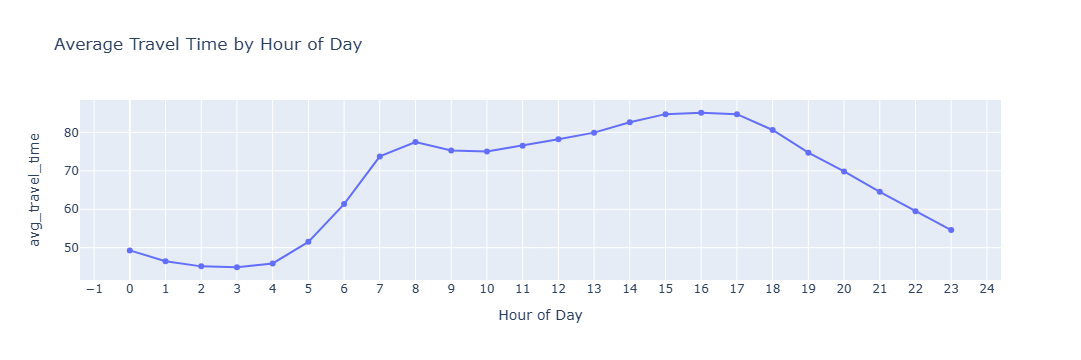

In [182]:
fig = px.line(hourly_avg_time, x='arrival_hour', y='avg_travel_time',
              labels={'arrival_hour': 'Hour of Day', 'travel_time': 'Avg Travel Time (sec)'},
              title='Average Travel Time by Hour of Day',
              markers=True)
fig.update_xaxes(dtick=1)
fig.show()

**Average Travel time per Service**

In [187]:
stops_and_times_trips = stops_and_times.merge(trips, on = 'trip_id', how = 'left')

In [188]:
trips_avg_time = stops_and_times_trips.groupby('service_id').agg(avg_travel_time = ('travel_time','mean')).reset_index()

In [189]:
service_avg_time = trips_avg_time.sort_values(by = 'avg_travel_time', ascending = False)

In [191]:
top5 = service_avg_time[:5]
top5

service_id  avg_travel_time
7   FB_B5-Weekday-SDon        93.761384
6        FB_B5-Weekday        92.849388
4       FB_B5-Saturday        85.003982
5         FB_B5-Sunday        78.111909
23  JG_B5-Weekday-SDon        77.369618

**Average Travel time. Weekdays vs Holidays**

In [201]:
calendar_and_trips = stops_and_times_trips.merge(calendar, on = 'service_id', how ='left')

In [204]:
week_avg = calendar_and_trips.groupby(['service_schedule']).agg(avg_travel_time = ('travel_time','mean')).reset_index()

In [206]:
week_avg

service_schedule  avg_travel_time
0                 Friday only        45.981308
1               Saturday only        68.988548
2                 Sunday only        64.888190
3           Weekday (Mon–Fri)        77.849226
4  Weekday (Mon–Thu) + Sunday        49.380531

**Longest Routes**

In [209]:
routes_and_trips = stops_and_times_trips.merge(routes, on = 'route_id', how ='left')

In [210]:
avg_time_routes = routes_and_trips.groupby('route_id').agg(avg_travel_time = ('travel_time', 'mean')).reset_index()
avg_time_routes = avg_time_routes.sort_values(by = 'avg_travel_time', ascending = False)

In [213]:
# top 5 
top5 = avg_time_routes[:5]
top5

route_id  avg_travel_time
26     B44+       184.134221
29     B46+       181.491304
51     B82+       156.312551
64      X38       150.345550
20      B39       141.206897

**Interactive Map**

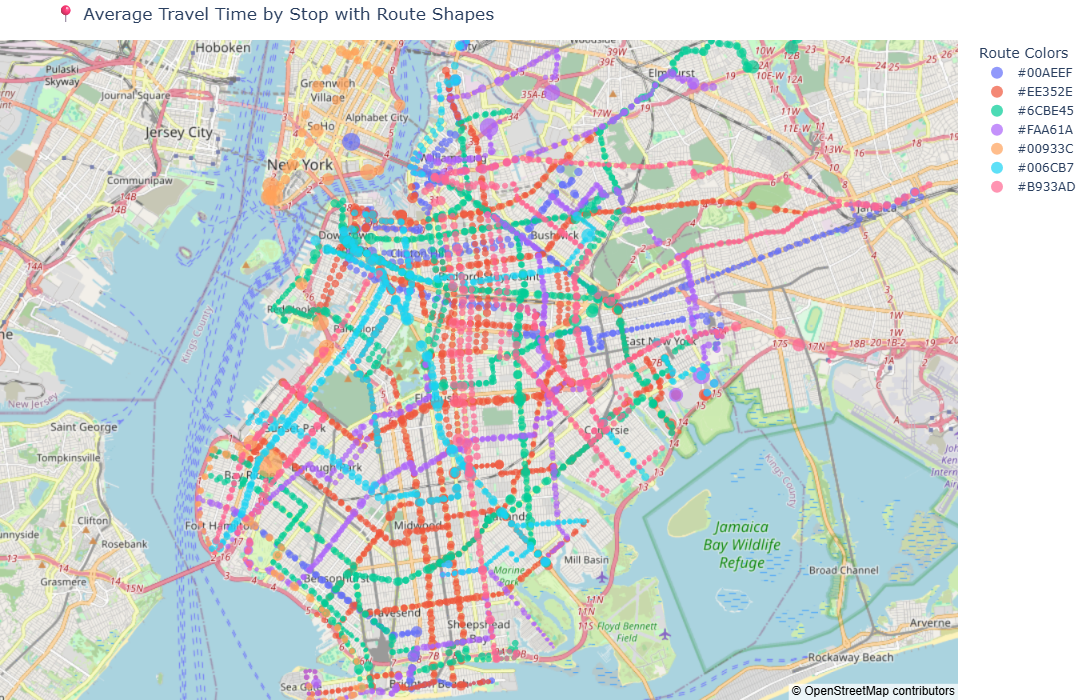

In [221]:


# --- Step 1: Aggregate stop-level average travel times ---
avg_time = routes_and_trips.groupby(
    ['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'route_color']
).agg(
    avg_travel_time=('travel_time', 'mean')
).reset_index()

avg_time['route_color'] = '#' + avg_time['route_color']

# --- Step 2: Plot stops with travel time size and color ---
stop_trace = px.scatter_mapbox(
    avg_time,
    lat="stop_lat",
    lon="stop_lon",
    size="avg_travel_time",
    color="route_color",
    hover_name="stop_name",
    hover_data=["avg_travel_time"],
    zoom=11,
    height=700
)
# --- Step 3: Plot route shapes (lines) from shapes.txt ---
# Ensure shape_points is sorted by sequence
shape_points = shapes.sort_values(by=['shape_id', 'shape_pt_sequence'])

# Create line traces for each shape_id
shape_traces = []
for shape_id, group in shape_points.groupby('shape_id'):
    shape_traces.append(
        go.Scattermapbox(
            lat=group['shape_pt_lat'],
            lon=group['shape_pt_lon'],
            mode='lines',
            line=dict(width=2, color='green'),
            name=f'Shape {shape_id}',
            hoverinfo='skip',
            showlegend=False
        )
    )

# --- Step 4: Combine all traces ---
fig = go.Figure()

# Add shapes (lines) first so stops appear on top
for trace in shape_traces:
    fig.add_trace(trace)

# Add stop bubbles
for trace in stop_trace.data:
    fig.add_trace(trace)

# --- Step 5: Map styling ---
stop_trace.update_layout(
    mapbox_style="open-street-map",
    mapbox_zoom=11,
    mapbox_center={"lat": avg_time['stop_lat'].mean(), "lon": avg_time['stop_lon'].mean()},
    title="📍 Average Travel Time by Stop with Route Shapes",
    legend=dict(title="Route Colors"),
    margin={"r":0,"t":40,"l":0,"b":0}
)

stop_trace.update_traces(marker=dict(opacity=0.7))
stop_trace.show()


**k-Means Clusters of Stops**

In [222]:
# Step 1: Group by stop to get average travel time and coordinates
stop_stats = routes_and_trips.groupby(
    ['stop_id', 'stop_name', 'stop_lat', 'stop_lon']
).agg(avg_travel_time=('travel_time', 'mean')).reset_index()

# Step 2: Standardize for clustering
scaler = StandardScaler()
features = scaler.fit_transform(stop_stats[['avg_travel_time', 'stop_lat', 'stop_lon']])

# Step 3: Apply K-Means (try 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
stop_stats['cluster'] = kmeans.fit_predict(features)


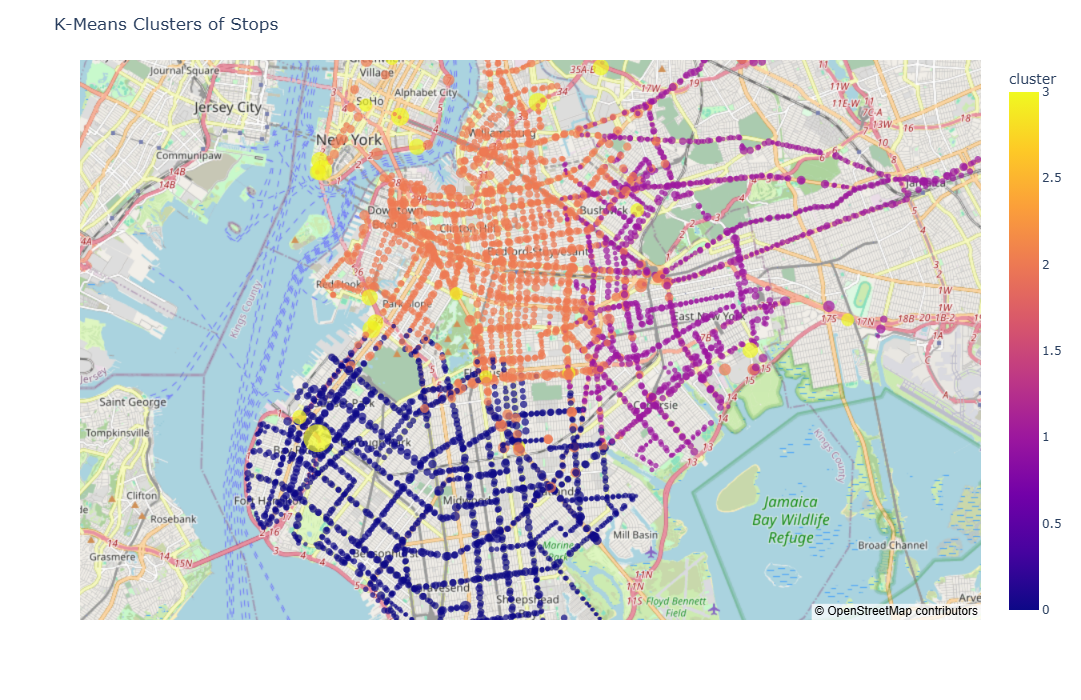

In [223]:
fig = px.scatter_mapbox(
    stop_stats,
    lat='stop_lat',
    lon='stop_lon',
    color='cluster',
    hover_name='stop_name',
    size='avg_travel_time',
    zoom=11,
    height=700
)
fig.update_layout(mapbox_style='open-street-map', title='K-Means Clusters of Stops')
fig.show()


**Cumulative Travel time per trip**

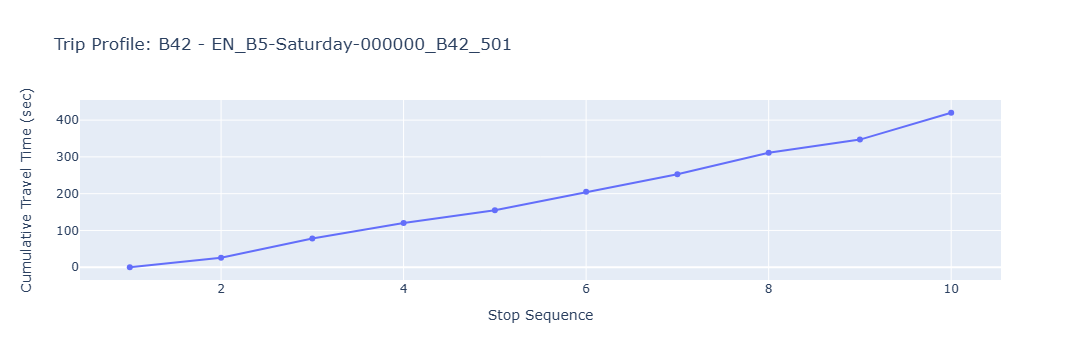

In [224]:

# Select a trip_id
sample_trip = routes_and_trips[routes_and_trips['trip_id'] == 'EN_B5-Saturday-000000_B42_501']

# Ensure data is sorted by stop sequence
sample_trip = sample_trip.sort_values('stop_sequence')

# Build cumulative time
sample_trip['cumulative_time'] = sample_trip['travel_time'].cumsum()

# Plot it
fig = px.line(
    sample_trip,
    x='stop_sequence',
    y='cumulative_time',
    hover_name='stop_name',
    markers=True,
    title=f"Trip Profile: {sample_trip['route_id'].iloc[0]} - {sample_trip['trip_id'].iloc[0]}"
)
fig.update_layout(xaxis_title='Stop Sequence', yaxis_title='Cumulative Travel Time (sec)')
fig.show()
